> 本notebook通过网络用户行为分析的例子，示例Bootstrap抽样方法在数据科学中应用

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
from pathlib import Path
from utilities import *

pd.set_option('precision', 2)

上面的代码导入必要包，和做合适的设置（显示合适的小数位数）等。同时`from utilities import *` 引入以下函数：

* `permutation`：对一个数组进行乱序抽样，主要用于Bootstrap方法；
* `plot_box`：绘制箱型图的函数；
* `plot_hist`：绘制直方图的函数

# 1. 用户访问停留时间 
---------------

## 1.1 数据集

In [2]:
data_folder = "../data"
web_data = "web_page_data.csv"

In [3]:
session_times = pd.read_csv(Path(data_folder) / web_data)
session_times.loc[:, 'Time'] *= 100.

In [4]:
session_times.tail()

,Page,Time
31,Page A,74.0
32,Page A,86.0
33,Page A,118.0
34,Page A,206.0
35,Page A,93.0


## 1.2 探索 - 利用统计特征以及绘图

In [5]:
session_times.groupby('Page').describe()

Time                                                 
       count    mean     std   min   25%    50%    75%    max
Page                                                         
Page A  21.0  126.33   88.46  21.0  67.0   95.0  173.0  342.0
Page B  15.0  162.00  101.14  43.0  80.0  147.0  234.5  357.0

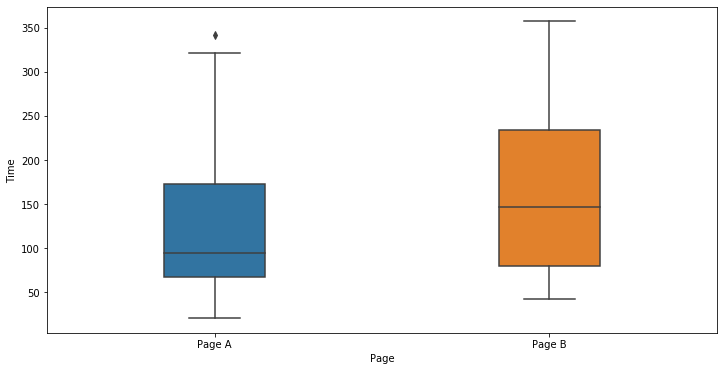

In [6]:
# Figure 3.3

fig, ax = plt.subplots(figsize=(12, 6))
plot_box(x='Page', y='Time', data=session_times, ax=ax)

## 1.3 基于Bootstrap的假设检验

* `n_perm`：抽样次数
* `mean_diff_perm`：每次抽样获得的页面差异指标；
* `sampled_mean_diff`：收集的`n_perm`次抽样的，页面指标差异的集合。

In [7]:
info_table = session_times.groupby('Page').agg(['count', 'mean'])
mean_diff = info_table.loc['Page B', ('Time', 'mean')] - info_table.loc['Page A', ('Time', 'mean')]

n_perm = 1000
session_values = session_times['Time'].values
n_A = int(info_table.loc['Page A', ('Time', 'count')])
n_B = int(info_table.loc['Page B', ('Time', 'count')])

sampled_mean_diff = []
for _ in range(n_perm):
    perm_A, perm_B = permutation(session_values, n_A, n_B)
    mean_diff_perm = np.mean(perm_B) - np.mean(perm_A)
    sampled_mean_diff.append(mean_diff_perm)

绘制直方图，并且将实际观测值（粗黑线）绘制到同一张图上；

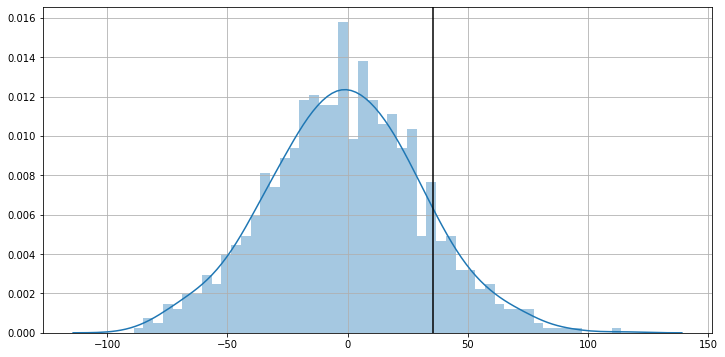

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_hist(sampled_mean_diff, mean_diff, ax)

同上，但是绘制的是基于累积概率的结果：

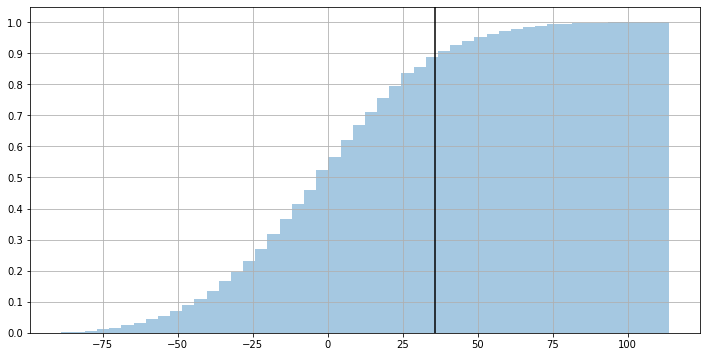

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_hist(sampled_mean_diff, mean_diff, ax, is_cum=True)

In [10]:
print(f"随机抽样大于观测值概率：{sum(sampled_mean_diff < mean_diff) / len(sampled_mean_diff) * 100.:.2f}%")

随机抽样大于观测值概率：87.80%


# 2. 用户购买转化
-------------------

获得的数据集：

| 结果   	| 价格 A 	| 价格 B 	|
|--------	|--------	|--------	|
| 购买   	| 182    	| 200    	|
| 未购买 	| 22588  	| 23739  	|

## 2.1 数据集

In [11]:
n_A = 22588
n_B = 23739
cn_A = 182
cn_B = 200

conversion_rate_A = cn_A / n_A * 100.
conversion_rate_B = cn_B / n_B * 100.
conversion_rate_diff = conversion_rate_B - conversion_rate_A

print(f"页面A的转化率: {conversion_rate_A:.2f}%")
print(f"页面B的转化率: {conversion_rate_B:.2f}%")
print(f"页面转化率变化: {conversion_rate_diff :.2f}%")

页面A的转化率: 0.81%
页面B的转化率: 0.84%
页面转化率变化: 0.04%


## 2.2 Bootstrap实验

* `n_perm`：抽样次数
* `mean_conversion_perm`：每次抽样获得的转化率差异指标；
* `sampled_conversion_diff`：收集的`n_perm`次抽样的，转化率差异指标的集合。

In [12]:
n_perm = 1000
sampled_conversion_diff = []
num_un_converted = n_A + n_B - cn_A - cn_B
num_converted = cn_A + cn_B
conversion_values = np.concatenate([np.zeros(num_un_converted), np.ones(num_converted)])
for _ in range(n_perm):
    perm_A, perm_B = permutation(conversion_values, n_A, n_B)
    mean_conversion_perm = np.mean(perm_B) * 100. - np.mean(perm_A) * 100.
    sampled_conversion_diff.append(mean_conversion_perm)

绘制直方图，并且将实际观测值（粗黑线）绘制到同一张图上；

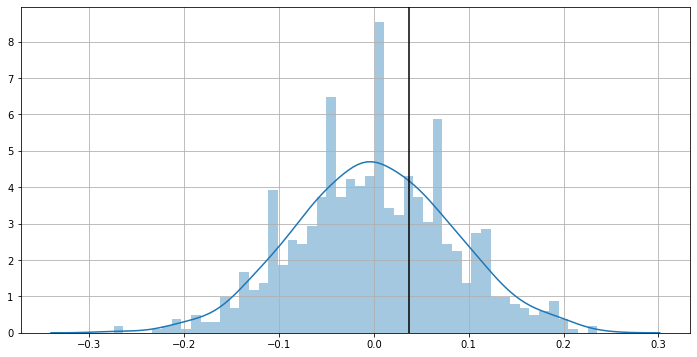

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_hist(sampled_conversion_diff, conversion_rate_diff, ax)

同上，但是绘制的是基于累积概率的结果：

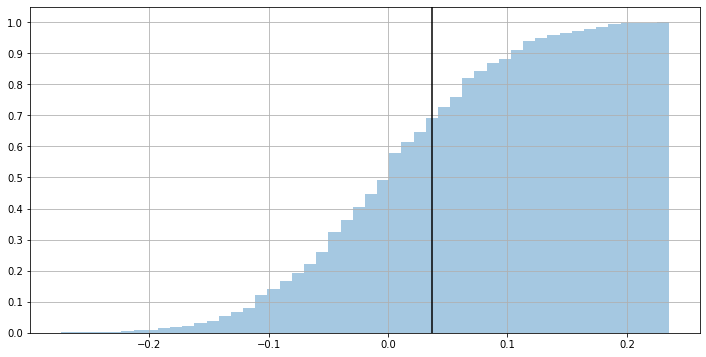

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_hist(sampled_conversion_diff, conversion_rate_diff, ax, is_cum=True)

In [15]:
print(f"随机抽样大于观测值概率：{sum(np.array(sampled_conversion_diff) < conversion_rate_diff) / len(sampled_conversion_diff) * 100.:.2f}%")

随机抽样大于观测值概率：64.60%


## 2.3 需要多大的样本容量？

为了回答整个问题，我们采用假想实验的方法，设计n组实验，每组都比上一组的样本扩大1倍。然后我们分别记录观测值在每个实验场景下的分位数。通过这个方法，获得信心（分位数）与样本容量的对应曲线：

* `num_fold`：实验数量
* `sampled_conversion_diff`：每组实验中获得的抽样结果；
* `covdiff_experiments`: 所有实验数据的集合；
* `res_df`：获得的曲线数据

# of samples: 46327; Q.: 0.654
# of samples: 92654; Q.: 0.715
# of samples: 185308; Q.: 0.767
# of samples: 370616; Q.: 0.904
# of samples: 741232; Q.: 0.957
# of samples: 1482464; Q.: 0.992
# of samples: 2964928; Q.: 1.0


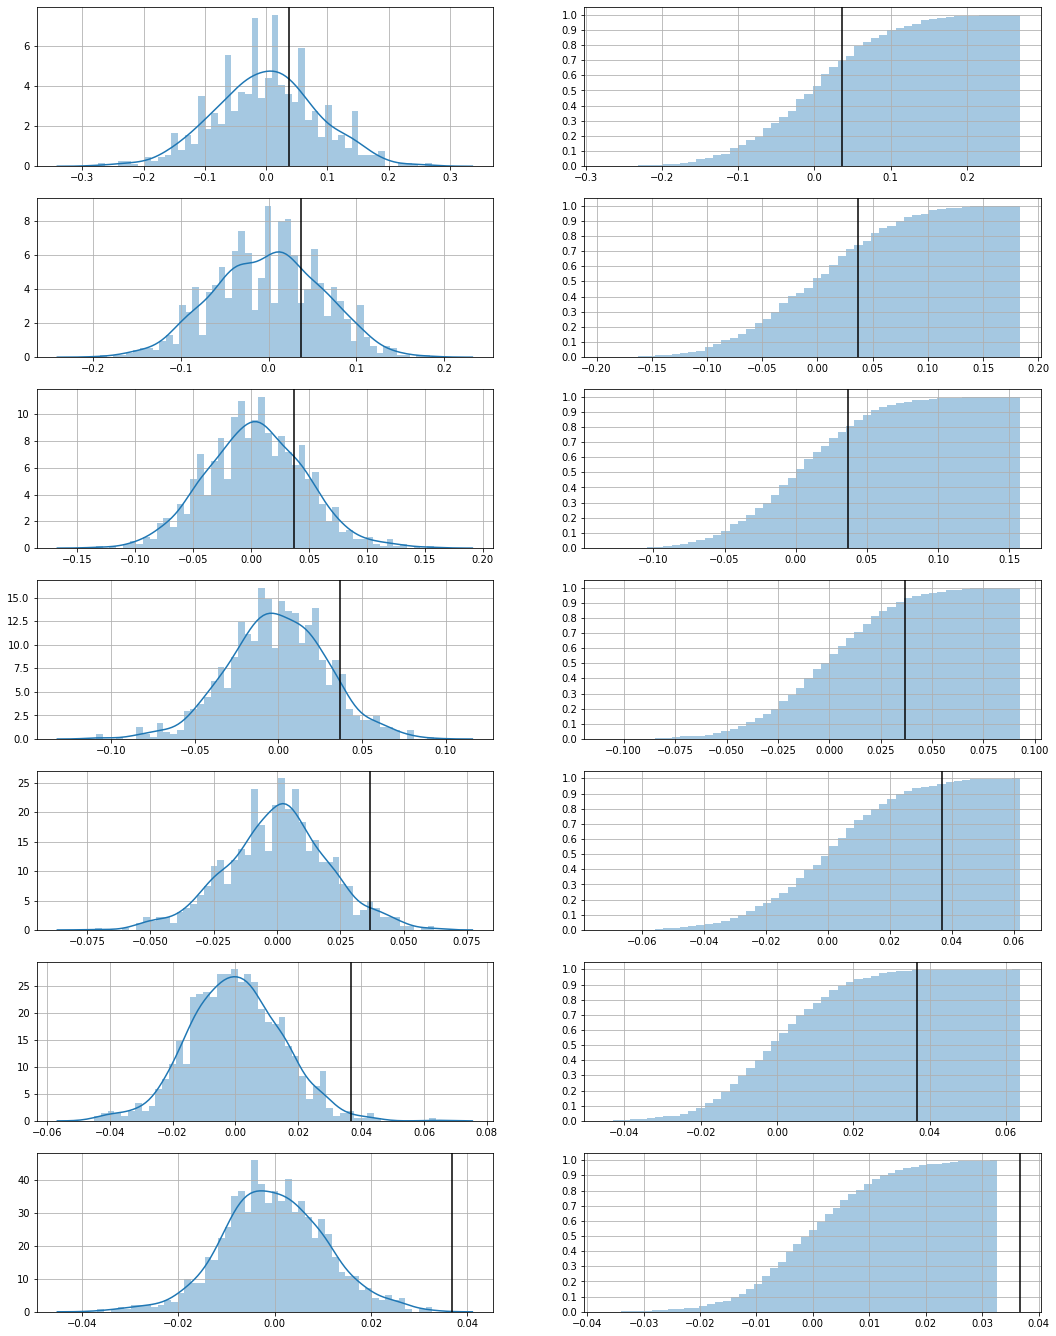

In [16]:
num_fold = 7
num_un_converted = n_A + n_B - cn_A - cn_B
num_converted = cn_A + cn_B
conversion_values = np.concatenate([np.zeros(num_un_converted), np.ones(num_converted)])

fig, axes = plt.subplots(nrows=num_fold, ncols=2, figsize=(18, 24))
covdiff_experiments = []

samples_df = pd.DataFrame(columns=['# of samples', 'confidence'])

for i in range(num_fold):
    n_perm = 1000
    sampled_conversion_diff = []
    factor = 2 ** i
    new_num_un_converted = num_un_converted * factor
    new_num_converted = num_converted * factor
    new_n_A = n_A * factor
    new_n_B = n_B * factor
    conversion_values = np.concatenate([np.zeros(new_num_un_converted), np.ones(new_num_converted)])
    for _ in range(n_perm):
        perm_A, perm_B = permutation(conversion_values, new_n_A, new_n_B)
        mean_conversion_perm = np.mean(perm_B) * 100. - np.mean(perm_A) * 100.
        sampled_conversion_diff.append(mean_conversion_perm)
    
    covdiff_experiments.append(sampled_conversion_diff)
    ax = axes[i, 0]
    plot_hist(sampled_conversion_diff, conversion_rate_diff, ax)
    
    ax = axes[i, 1]
    plot_hist(sampled_conversion_diff, conversion_rate_diff, ax, is_cum=True)
    
    print(f"# of samples: {new_num_un_converted + new_num_converted}; Q.: {sum(conversion_rate_diff > np.array(sampled_conversion_diff)) / len(sampled_conversion_diff)}")
    samples_df.loc[i, '# of samples'] = new_num_un_converted + new_num_converted
    samples_df.loc[i, 'confidence'] = sum(conversion_rate_diff > np.array(sampled_conversion_diff)) / len(sampled_conversion_diff)

我们绘制曲线:

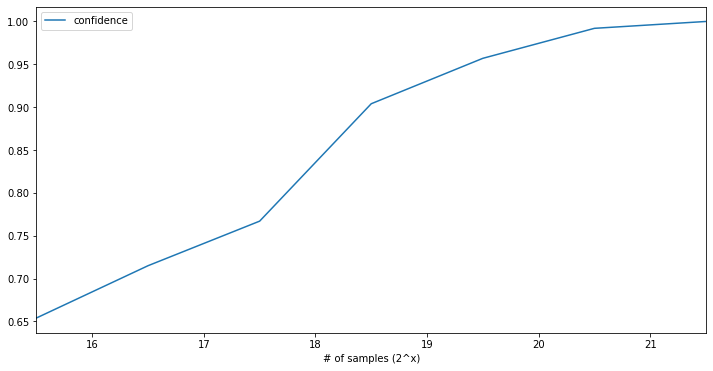

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))
samples_df['# of samples (2^x)'] = np.log2(samples_df['# of samples'].astype(float))
samples_df.plot(x='# of samples (2^x)', y='confidence', ax=ax)

## 2.3 需要多显著的数据变化？

利用上面同样的采用数据，我们换一个角度去分析：

* 考虑95%与99%两个信心的水平；
* 计算不同的样本容量下，达到这两个信心度，需要观察到的变化；
* 将其绘制成曲线；

In [18]:
threshold_df = pd.DataFrame(columns=['# of samples', '95%', '99%'])

for i, sample_data in enumerate(covdiff_experiments):
    print(f"\n# of samples: {(n_A + n_B) * (2 ** i)}")
    print(f"Current : {conversion_rate_diff:.2f}%; \
          Rel. {conversion_rate_diff / conversion_rate_A * 100.:.2f}%")
    print(f"95% Sig.: {np.quantile(sample_data, 0.95):.2f}%; \
          Rel. {np.quantile(sample_data, 0.95) / conversion_rate_A * 100.:.2f}%")
    print(f"99% Sig.: {np.quantile(sample_data, 0.99):.2f}%; \
          Rel. {np.quantile(sample_data, 0.99) / conversion_rate_A * 100.:.2f}%")
    
    threshold_df.loc[i, '# of samples'] = (n_A + n_B) * (2 ** i)
    threshold_df.loc[i, '95%'] = np.quantile(sample_data, 0.95) / conversion_rate_A * 100.
    threshold_df.loc[i, '99%'] = np.quantile(sample_data, 0.99) / conversion_rate_A * 100.


# of samples: 46327
Current : 0.04%;           Rel. 4.56%
95% Sig.: 0.14%;           Rel. 17.43%
99% Sig.: 0.19%;           Rel. 23.86%

# of samples: 92654
Current : 0.04%;           Rel. 4.56%
95% Sig.: 0.10%;           Rel. 12.60%
99% Sig.: 0.13%;           Rel. 16.36%

# of samples: 185308
Current : 0.04%;           Rel. 4.56%
95% Sig.: 0.07%;           Rel. 9.12%
99% Sig.: 0.11%;           Rel. 13.68%

# of samples: 370616
Current : 0.04%;           Rel. 4.56%
95% Sig.: 0.05%;           Rel. 5.64%
99% Sig.: 0.07%;           Rel. 8.45%

# of samples: 741232
Current : 0.04%;           Rel. 4.56%
95% Sig.: 0.04%;           Rel. 4.36%
99% Sig.: 0.05%;           Rel. 5.84%

# of samples: 1482464
Current : 0.04%;           Rel. 4.56%
95% Sig.: 0.03%;           Rel. 3.16%
99% Sig.: 0.04%;           Rel. 4.43%

# of samples: 2964928
Current : 0.04%;           Rel. 4.56%
95% Sig.: 0.02%;           Rel. 2.18%
99% Sig.: 0.03%;           Rel. 3.16%


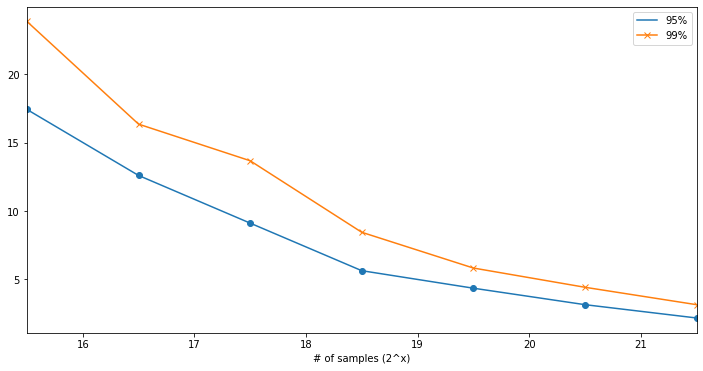

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))
threshold_df['# of samples (2^x)'] = np.log2(threshold_df['# of samples'].astype(float))
threshold_df.plot(x='# of samples (2^x)', y='95%', marker='o', ax=ax)
threshold_df.plot(x='# of samples (2^x)', y='99%', marker='x', ax=ax)